In [1]:
import os
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import layers, models

In [2]:
csv_path = 'combined_labels_old.csv'
df = pd.read_csv(csv_path)
df

,File Name,Label
0,common_voice_ta_31833527.wav,Tamil
1,common_voice_en_38025497.wav,English
2,common_voice_ta_31833176.wav,Tamil
3,common_voice_fr_34952338.wav,French
4,common_voice_en_38025197.wav,English
...,...,...
1995,common_voice_de_36533365.wav,German
1996,common_voice_pt_36535343.wav,Portuguese
1997,common_voice_pt_36535392.wav,Portuguese
1998,common_voice_fr_34930251.wav,French


In [3]:
shuffled_df = df.sample(frac=1).reset_index(drop=True)
#shuffled_df = shuffled_df[0:3000]


In [4]:
shuffled_df

,File Name,Label
0,common_voice_en_38025697.wav,English
1,common_voice_en_38025163.wav,English
2,common_voice_fr_34938898.wav,French
3,common_voice_en_38024683.wav,English
4,common_voice_fr_34930312.wav,French
...,...,...
1995,common_voice_pt_36534799.wav,Portuguese
1996,common_voice_en_38025545.wav,English
1997,common_voice_pt_36534257.wav,Portuguese
1998,common_voice_de_36533353.wav,German


In [5]:
data = {'language': ['Tamil', 'French', 'English', 'German', 'Portuguese', 'English', 'Tamil', 'French']}

label_counts = shuffled_df['Label'].value_counts()
print("Data distribution for each label:")
print(label_counts)

Data distribution for each label:
English       400
French        400
German        400
Portuguese    400
Tamil         400
Name: Label, dtype: int64


In [6]:
audio_dir = 'Data'

In [7]:
def load_and_preprocess(file_path):
    audio, _ = librosa.load(file_path, res_type='kaiser_fast', duration=2.5, sr=22050, offset=0.5)
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)
    return mfccs

In [8]:
# Create a list to store MFCCs and labels
mfccs_list = []
labels = []

In [9]:
for index, row in shuffled_df.iterrows():
    file_path = os.path.join(audio_dir, row['File Name'])
    mfccs = load_and_preprocess(file_path)
    mfccs_list.append(mfccs.T)
    labels.append(row['Label'])

In [10]:
print(len(mfccs_list))
print(len(labels))

2000
2000


In [11]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_mfccs = pad_sequences(mfccs_list, dtype='float32', padding='post', truncating='post')

print(padded_mfccs.shape)

(2000, 108, 13)


In [12]:
X = np.array(padded_mfccs)
y = np.array(labels)

In [13]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [15]:
print(X_train[1].shape)

(108, 13)


In [16]:
from tensorflow.keras import models, layers

model_dnn = keras.Sequential([
    layers.Input(shape=(X.shape[1], X.shape[2])),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(5, activation='softmax')
])

In [17]:
print(model_dnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 108, 128)          1792      
                                                                 
 dropout (Dropout)           (None, 108, 128)          0         
                                                                 
 dense_1 (Dense)             (None, 108, 64)           8256      
                                                                 
 dropout_1 (Dropout)         (None, 108, 64)           0         
                                                                 
 dense_2 (Dense)             (None, 108, 32)           2080      
                                                                 
 dropout_2 (Dropout)         (None, 108, 32)           0         
                                                                 
 flatten (Flatten)           (None, 3456)              0

In [18]:
model_dnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = model_dnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
50/50 [==============================] - 3s 41ms/step - loss: 6.7677 - accuracy: 0.2237 - val_loss: 1.5797 - val_accuracy: 0.2875
Epoch 2/50
50/50 [==============================] - 2s 35ms/step - loss: 1.7640 - accuracy: 0.2600 - val_loss: 1.5389 - val_accuracy: 0.4100
Epoch 3/50
50/50 [==============================] - 2s 33ms/step - loss: 1.5855 - accuracy: 0.3256 - val_loss: 1.4046 - val_accuracy: 0.4275
Epoch 4/50
50/50 [==============================] - 2s 40ms/step - loss: 1.4941 - accuracy: 0.3663 - val_loss: 1.2166 - val_accuracy: 0.5125
Epoch 5/50
50/50 [==============================] - 1s 29ms/step - loss: 1.2818 - accuracy: 0.4544 - val_loss: 1.0262 - val_accuracy: 0.5775
Epoch 6/50
50/50 [==============================] - 1s 24ms/step - loss: 1.1180 - accuracy: 0.5281 - val_loss: 0.9126 - val_accuracy: 0.6075
Epoch 7/50
50/50 [==============================] - 1s 28ms/step - loss: 0.9852 - accuracy: 0.5756 - val_loss: 0.8621 - val_accuracy: 0.6325
Epoch 8/50
50

<Figure size 1200x400 with 0 Axes>

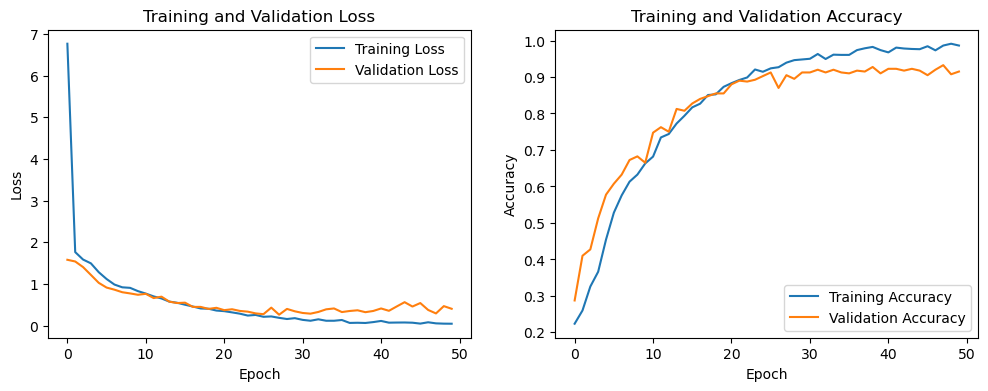

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.figure(figsize=(12, 4))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [21]:
from sklearn.metrics import classification_report

In [22]:
y_pred_prob = model_dnn.predict(X_test)

13/13 [==============================] - 0s 6ms/step


In [23]:
y_pred_labels = np.argmax(y_pred_prob, axis=1)

In [24]:
y_test_labels = le.inverse_transform(y_test)

In [25]:
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.915


In [26]:
from sklearn.metrics import classification_report

In [27]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        75
           1       0.92      0.80      0.85        83
           2       0.91      0.87      0.89        86
           3       0.95      0.93      0.94        87
           4       0.97      1.00      0.99        69

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.91       400



## Personal English Voice

In [28]:
test_audio_path = 'english_test_audio.wav'
test_mfccs = load_and_preprocess(test_audio_path)

In [29]:
padded_test_mfccs = pad_sequences([test_mfccs.T], dtype='float32', padding='post', truncating='post')


In [30]:
X_test_sample = np.array(padded_test_mfccs)

In [31]:
predictions = model_dnn.predict(X_test_sample)

1/1 [==============================] - 0s 17ms/step


In [32]:
predicted_label_index = np.argmax(predictions)
predicted_label = le.inverse_transform([predicted_label_index])[0]

print(f'Predicted Language: {predicted_label}')

Predicted Language: English


# English VoxLingual Test

In [33]:
test_folder_path = 'English_test_Vox'

In [34]:
english_count = 0

for filename in os.listdir(test_folder_path):
    if filename.endswith(".wav"):
        test_audio_path = os.path.join(test_folder_path, filename)

        test_mfccs = load_and_preprocess(test_audio_path)
        padded_test_mfccs = pad_sequences([test_mfccs.T], dtype='float32', padding='post', truncating='post')

        X_test_sample = np.array(padded_test_mfccs)

        
        predictions = model_dnn.predict(X_test_sample)

        
        predicted_label_index = np.argmax(predictions)
        predicted_label = le.inverse_transform([predicted_label_index])[0]

        print(f'File: {filename}, Predicted Language: {predicted_label}')

        if predicted_label == 'English':
            english_count += 1


1/1 [==============================] - 0s 20ms/step
File: _e4fgbYJsYM__U__S0---0366.650-0375.120.wav, Predicted Language: German
1/1 [==============================] - 0s 18ms/step
File: _e4fgbYJsYM__U__S0---0376.220-0382.610.wav, Predicted Language: German
1/1 [==============================] - 0s 19ms/step
File: _e4fgbYJsYM__U__S0---0524.480-0539.440.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: _e4fgbYJsYM__U__S0---0954.160-0969.530.wav, Predicted Language: English
1/1 [==============================] - 0s 18ms/step
File: _e4fgbYJsYM__U__S1---0085.040-0101.490.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: _e4fgbYJsYM__U__S1---0101.490-0108.830.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: _e4fgbYJsYM__U__S1---0128.750-0137.040.wav, Predicted Language: English
1/1 [==============================] - 0s 20ms/step
File: _e4fgbYJsYM__U__S1---0137.040-0142

1/1 [==============================] - 0s 20ms/step
File: _e4fgbYJsYM__U__S105---0657.000-0670.360.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: _e4fgbYJsYM__U__S105---0784.720-0790.460.wav, Predicted Language: English
1/1 [==============================] - 0s 18ms/step
File: _e4fgbYJsYM__U__S105---0790.460-0805.010.wav, Predicted Language: English
1/1 [==============================] - 0s 18ms/step
File: _e4fgbYJsYM__U__S105---0871.580-0882.460.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: _e4fgbYJsYM__U__S107---0067.170-0074.660.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: _e4fgbYJsYM__U__S107---0670.360-0679.430.wav, Predicted Language: English
1/1 [==============================] - 0s 18ms/step
File: _e4fgbYJsYM__U__S107---0714.900-0727.300.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: _e4fgbYJsYM__U__S1

In [35]:
print(f'Total English Predictions: {english_count}')

Total English Predictions: 89


In [36]:
test_folder_path = 'German_test_Vox'

German_count = 0

for filename in os.listdir(test_folder_path):
    if filename.endswith(".wav"):
        test_audio_path = os.path.join(test_folder_path, filename)

        test_mfccs = load_and_preprocess(test_audio_path)
        padded_test_mfccs = pad_sequences([test_mfccs.T], dtype='float32', padding='post', truncating='post')

        X_test_sample = np.array(padded_test_mfccs)

        
        predictions = model_dnn.predict(X_test_sample)

        
        predicted_label_index = np.argmax(predictions)
        predicted_label = le.inverse_transform([predicted_label_index])[0]

        print(f'File: {filename}, Predicted Language: {predicted_label}')

        if predicted_label == 'German':
            German_count += 1


1/1 [==============================] - 0s 19ms/step
File: 0GLLVyNCo3Y__U__S1---0004.530-0021.000.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 18ms/step
File: 0GLLVyNCo3Y__U__S4---0021.000-0037.560.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 19ms/step
File: 0GLLVyNCo3Y__U__S4---0037.560-0053.560.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 19ms/step
File: 0MsifTxSdKw__U__S0---0150.320-0163.790.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 19ms/step
File: 0MsifTxSdKw__U__S0---0164.400-0179.760.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 19ms/step
File: 0MsifTxSdKw__U__S0---0251.380-0261.620.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 18ms/step
File: 0MsifTxSdKw__U__S0---0398.450-0406.110.wav, Predicted Language: Portuguese
1/1 [==============================] - 0s 19ms/step
File: 0MsifTxSdKw

1/1 [==============================] - 0s 19ms/step
File: _zTNE3kvaGg__U__S108---0915.050-0922.230.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: _zTNE3kvaGg__U__S108---0928.770-0935.790.wav, Predicted Language: English
1/1 [==============================] - 0s 20ms/step
File: _zTNE3kvaGg__U__S108---0937.030-0940.360.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: _zTNE3kvaGg__U__S108---0940.360-0946.000.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: _zTNE3kvaGg__U__S108---0946.000-0964.760.wav, Predicted Language: English
1/1 [==============================] - 0s 20ms/step
File: _zTNE3kvaGg__U__S108---0964.760-0975.170.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: _zTNE3kvaGg__U__S150---0984.770-0991.090.wav, Predicted Language: English
1/1 [==============================] - 0s 18ms/step
File: _zTNE3kvaGg__U__S1

In [37]:
print(f'Total German Predictions: {German_count}')

Total German Predictions: 1


In [38]:
test_folder_path = 'Portuguese_test_Vox'

Portuguese_count = 0
# Iterate through all WAV files in the folder
for filename in os.listdir(test_folder_path):
    if filename.endswith(".wav"):
        test_audio_path = os.path.join(test_folder_path, filename)

        test_mfccs = load_and_preprocess(test_audio_path)
        padded_test_mfccs = pad_sequences([test_mfccs.T], dtype='float32', padding='post', truncating='post')

        X_test_sample = np.array(padded_test_mfccs)

        
        predictions = model_dnn.predict(X_test_sample)

        
        predicted_label_index = np.argmax(predictions)
        predicted_label = le.inverse_transform([predicted_label_index])[0]

        print(f'File: {filename}, Predicted Language: {predicted_label}')

        if predicted_label == 'Portuguese':
            Portuguese_count += 1

1/1 [==============================] - 0s 19ms/step
File: 0RqxhbSC1qE__U__S1---0011.370-0018.140.wav, Predicted Language: German
1/1 [==============================] - 0s 18ms/step
File: 0RqxhbSC1qE__U__S1---0018.480-0024.450.wav, Predicted Language: German
1/1 [==============================] - 0s 18ms/step
File: 0RqxhbSC1qE__U__S1---0024.630-0032.410.wav, Predicted Language: German
1/1 [==============================] - 0s 18ms/step
File: 0RqxhbSC1qE__U__S1---0061.140-0067.480.wav, Predicted Language: German
1/1 [==============================] - 0s 19ms/step
File: 0RqxhbSC1qE__U__S1---0235.420-0239.590.wav, Predicted Language: German
1/1 [==============================] - 0s 18ms/step
File: 0RqxhbSC1qE__U__S1---0249.890-0257.460.wav, Predicted Language: German
1/1 [==============================] - 0s 19ms/step
File: 0RqxhbSC1qE__U__S1---0258.150-0264.620.wav, Predicted Language: German
1/1 [==============================] - 0s 19ms/step
File: 0RqxhbSC1qE__U__S1---0444.870-0450.020.

1/1 [==============================] - 0s 20ms/step
File: 0RqxhbSC1qE__U__S1---2875.880-2880.200.wav, Predicted Language: German
1/1 [==============================] - 0s 18ms/step
File: 0RqxhbSC1qE__U__S1---2915.860-2919.680.wav, Predicted Language: German
1/1 [==============================] - 0s 18ms/step
File: 0RqxhbSC1qE__U__S10---0075.870-0080.440.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: 0RqxhbSC1qE__U__S10---0087.050-0090.680.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: 0RqxhbSC1qE__U__S38---0267.840-0278.060.wav, Predicted Language: German
1/1 [==============================] - 0s 18ms/step
File: 0RqxhbSC1qE__U__S38---0310.240-0318.790.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: 0RqxhbSC1qE__U__S38---0318.950-0325.480.wav, Predicted Language: German
1/1 [==============================] - 0s 20ms/step
File: 0RqxhbSC1qE__U__S38---0352.070-

In [39]:
print(f'Total Portuguese Predictions: {Portuguese_count}')

Total Portuguese Predictions: 3


In [40]:
test_folder_path = 'French_test_Vox'

French_count = 0
# Iterate through all WAV files in the folder
for filename in os.listdir(test_folder_path):
    if filename.endswith(".wav"):
        test_audio_path = os.path.join(test_folder_path, filename)

        test_mfccs = load_and_preprocess(test_audio_path)
        padded_test_mfccs = pad_sequences([test_mfccs.T], dtype='float32', padding='post', truncating='post')

        X_test_sample = np.array(padded_test_mfccs)

        
        predictions = model_dnn.predict(X_test_sample)

        
        predicted_label_index = np.argmax(predictions)
        predicted_label = le.inverse_transform([predicted_label_index])[0]

        print(f'File: {filename}, Predicted Language: {predicted_label}')

        if predicted_label == 'French':
            French_count += 1

1/1 [==============================] - 0s 19ms/step
File: 1KYGVamLYNU__U__S100---0540.210-0544.030.wav, Predicted Language: English
1/1 [==============================] - 0s 18ms/step
File: 1KYGVamLYNU__U__S100---0545.090-0555.380.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: 1KYGVamLYNU__U__S100---0614.250-0627.670.wav, Predicted Language: English
1/1 [==============================] - 0s 18ms/step
File: 1KYGVamLYNU__U__S100---0627.670-0636.600.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: 1KYGVamLYNU__U__S104---0637.720-0647.660.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: 1KYGVamLYNU__U__S108---0668.190-0676.540.wav, Predicted Language: English
1/1 [==============================] - 0s 18ms/step
File: 1KYGVamLYNU__U__S109---0677.520-0696.500.wav, Predicted Language: English
1/1 [==============================] - 0s 19ms/step
File: 1KYGVamLYNU__U__S1

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/flatten/Reshape' defined at (most recent call last):
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_15824\593903857.py", line 15, in <cell line: 5>
      predictions = model_dnn.predict(X_test_sample)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
      return self(x, training=False)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ASUS\anaconda3\envs\tensorflow\lib\site-packages\keras\layers\reshaping\flatten.py", line 98, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential/flatten/Reshape'
Input to reshape is a tensor with 2304 values, but the requested shape requires a multiple of 3456
	 [[{{node sequential/flatten/Reshape}}]] [Op:__inference_predict_function_35995]

In [ ]:
print(f'Total French Predictions: {French_count}')